# Implementation of Denoising Diffusion Model

![diffusion generated](../figures/chapter4/part3-diffusion-generated.png)

[Jupyter Notebook](https://colab.research.google.com/drive/1leq-Ke1WpSeujoYFVCEGAByTYaEJ7A1X?usp=sharing)

## Data Preparation

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
def prepare_dataset(batch_size):
    preprocessor = transforms.ToTensor()
    dataset = datasets.FashionMNIST(root="./data", download=True, transform=preprocessor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [3]:
batch_size = 128

dataloader = prepare_dataset(batch_size)

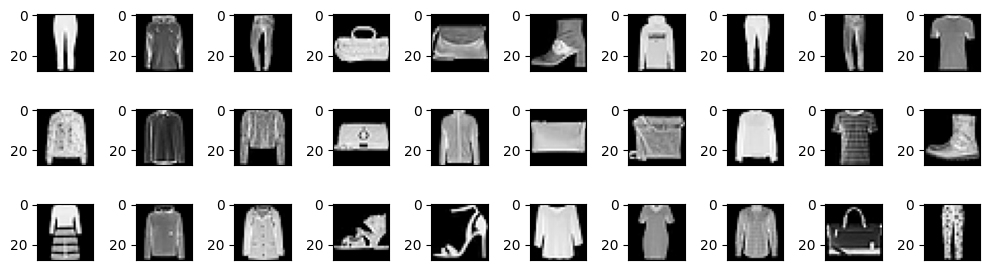

In [4]:
import matplotlib.pyplot as plt

def show_images(images, labels=None, cols=10, rows=3):
    figures = plt.figure(figsize=(cols, rows))
    idx = 0
    for r in range(rows):
        for c in range(cols):
          ax = figures.add_subplot(rows, cols, idx+1)
          plt.imshow(images[idx], cmap="gray")

          if labels is not None:
            ax.set_xlabel(labels[idx])
          ax.get_xaxis().set_ticks([])
          ax.get_xaxis().set_ticks([])
          idx += 1

    plt.tight_layout()
    plt.show()

def save_images(images, labels=None, cols=10, rows=3, save_path="images.png"):
    figures = plt.figure(figsize=(cols, rows))
    idx = 0
    for r in range(rows):
        for c in range(cols):
          ax = figures.add_subplot(rows, cols, idx+1)
          plt.imshow(images[idx], cmap="gray")

          if labels is not None:
              ax.set_xlabel(labels[idx])
          ax.get_xaxis().set_ticks([])
          ax.get_xaxis().set_ticks([])
          idx += 1

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

data_iter = iter(dataloader)
images, labels = next(data_iter)
show_images([img[0] for img in images])

## Model Preparation

In [5]:
import torch
import torch.nn as nn

In [6]:
def time_embedding(time_steps, time_dim, device='cpu'):
    max_time = len(time_steps)
    embeddings = torch.zeros(max_time, time_dim, device=device)

    idx = torch.arange(0, time_dim, device=device)
    div_term = torch.exp(idx / (2 * time_dim) * torch.log(torch.tensor(10000.0)))

    for t in range(max_time):
        embeddings[t, 0::2] = torch.sin(time_steps[t] / div_term[::2])
        embeddings[t, 1::2] = torch.cos(time_steps[t]  / div_term[1::2])

    return embeddings

We use [UNet](https://arxiv.org/abs/1505.04597) (Ronneberger et al. 2015; MICCAI 2015) in this example.
![Unet](../figures/chapter5/unet.png)

In [7]:
class ConvBlock(nn.Module):
    """
    A convolutional block with time embedding.
    """
    def __init__(self, in_channels, out_channels, time_dim):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            time_dim (int): Dimension of the time embedding.
        """
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.linear = nn.Sequential(
            nn.Linear(time_dim, in_channels*2),
            nn.ReLU(),
            nn.Linear(in_channels*2, in_channels)
        )

    def forward(self, x, t=None):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        if t is not None:
            t = self.linear(t)
            t = t.view(x.size(0), -1, 1, 1)
            x = x + t
        x = self.conv(x)

        return x


class UNetWithTime(nn.Module):
    """
    A U-Net model with time embedding.
    """
    def __init__(self, in_channels=1, out_channels=1, time_dim=512):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            time_dim (int): Dimension of the time embedding.
        """
        super(UNetWithTime, self).__init__()
        self.time_dim = time_dim

        self.time_embedding = time_embedding
        # down sampling
        self.down_conv1 = ConvBlock(in_channels, 64, time_dim)
        self.down_conv2 = ConvBlock(64, 128, time_dim)
        # bottleneck
        self.bottleneck = ConvBlock(128, 256, time_dim)
        # up sampling
        self.up_conv2 = ConvBlock(256+128, 128, time_dim) # concat with down sampling
        self.up_conv1 = ConvBlock(128+64, 64, time_dim) # concat with down sampling
        # output
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        # max pooling
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # up sampling
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, time_steps):
        """
        Args:
            x (torch.Tensor): Input tensor.
            time_steps (torch.Tensor): Time steps.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        t = self.time_embedding(time_steps, self.time_dim, device=x.device)
        x1 = self.down_conv1(x, t)
        x = self.max_pool(x1)
        x2 = self.down_conv2(x, t)
        x = self.max_pool(x2)
        x = self.bottleneck(x, t)
        x = self.up_sample(x)
        x = self.up_conv2(torch.cat([x, x2], dim=1), t)
        x = self.up_sample(x)
        x = self.up_conv1(torch.cat([x, x1], dim=1), t)
        x = self.out(x)

        return x

### Diffusion and Denoising

In [8]:
class Diffuser:
    def __init__(self, max_steps, beta_start=0.001, beta_end=0.01, device='cpu'):
        """
        Args:
            max_steps (int): Maximum number of steps in diffusion step.
            beta_start (float): Initial value of beta.
            beta_end (float): Final value of beta.
        """
        self.device = device
        self.max_steps = max_steps
        self.betas = torch.linspace(beta_start, beta_end, max_steps, device=self.device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = self.alphas.cumprod(dim=0)

    def diffuse(self, x, t):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        noise = torch.randn_like(x, device=self.device)
        alpha_cumprod = self.alphas_cumprod[t-1].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_cumprod) * x + torch.sqrt(1 - alpha_cumprod) * noise

        return x_t, noise

    def denoise(self, model, x, t):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        _t = t-1
        alpha = self.alphas[_t].view(-1, 1, 1, 1)
        alpha_cumprod = self.alphas_cumprod[_t].view(-1, 1, 1, 1)
        alpha_cumprod_prev = self.alphas_cumprod[_t-1].view(-1, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            pred_noise = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_cumprod)) * pred_noise) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_cumprod_prev) / (1-alpha_cumprod))
        return mu + noise * std

    def convert_to_image(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        return x

    def sample(self, model, sample_shape=(1, 1, 28, 28)):
        bsz = sample_shape[0]
        x = torch.randn(sample_shape, device=self.device)

        for i in range(self.max_steps, 0, -1):
            t = torch.tensor([i] * bsz, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)

        x = torch.stack([self.convert_to_image(x[i]) for i in range(bsz)])
        return x


### Training

In [9]:
import os
from torch.optim import Adam
import torch.nn.functional as F

In [10]:
# Hyperparameters
in_channels = 1
img_size = 28
batch_size = 128
max_steps = 1000
time_dim = 100
lr = 1e-3
epochs = 10
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
   device = 'cpu'

# Prepare dataset
dataloader = prepare_dataset(batch_size)

# Initialize model and diffuser
model = UNetWithTime(in_channels=in_channels, time_dim=time_dim).to(device)
diffuser = Diffuser(max_steps=max_steps, device=device)
optimizer = Adam(model.parameters(), lr=lr)

In [11]:
def train(epochs, model, diffuser, optimizer, dataloader, max_steps, img_size, batch_size, device):
    # Training loop
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        cnt = 0

        images = diffuser.sample(model, (64, 1, img_size, img_size))
        print(len(images))
        show_images([img[0] for img in images.to('cpu')])

        #os.makedirs("data/FashionMNIST/generated", exist_ok=True)
        #save_images([img[0] for img in images.to('cpu')], save_path=f"data/FashionMNIST/generated/images_{epoch}.png")

        for images, labels in dataloader:
            optimizer.zero_grad()
            x = images.to(device)
            t = torch.randint(1, max_steps+1, (len(x),), device=device)

            x_noisy, noise = diffuser.diffuse(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise, noise_pred)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            cnt += 1

        loss_avg = loss_sum / cnt
        losses.append(loss_avg)
        print(f'Epoch {epoch} | Loss: {loss_avg}')

    # save model
    #torch.save(model.state_dict(), "data/FashionMNIST/model.pth")
    return losses

64


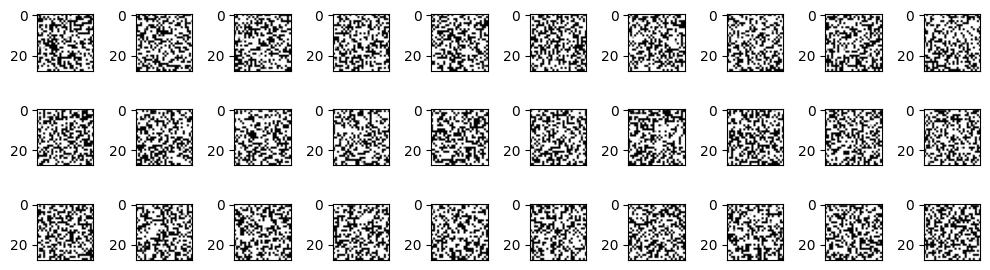

Epoch 0 | Loss: 0.05612272237028394
64


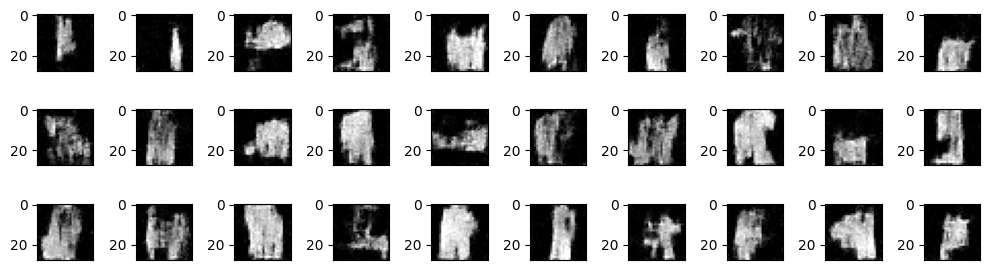

Epoch 1 | Loss: 0.03324329410629994
64


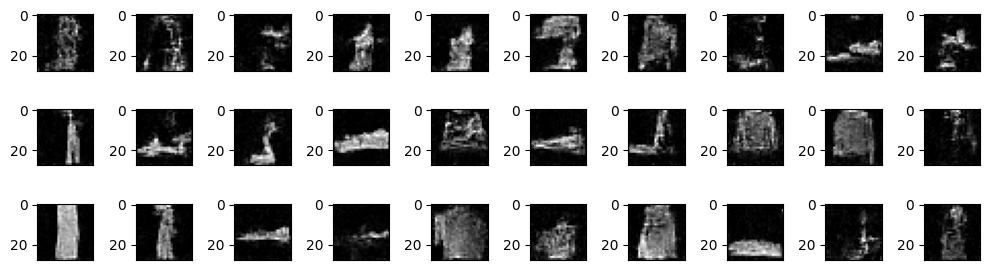

Epoch 2 | Loss: 0.02995353312428191
64


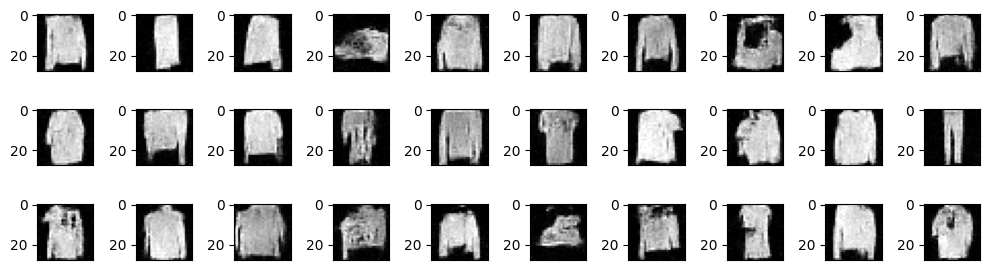

In [12]:
losses = train(epochs, model, diffuser, optimizer, dataloader, max_steps, img_size, batch_size, device)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig("data/FashionMNIST/generated/loss.png")
plt.close()

images = diffuser.sample(model, (batch_size, 1, img_size, img_size))
show_images([img[0] for img in images.to('cpu')])

## Conditional Diffusion Model

In previous chapters, we have formulated generative model as probabilistic distribution $p(x)$ of observed data $x$.
However, in reality, we may want to control the generative data with specific conditions $\left(p(x|y)\right)$ rather than in a random way.
For example, we may want to generate an image of a cat in a specific pose, or a person in a particular hair style.
Conditional diffusion models excel at this type of task, allowing us to steer the generative process towards desired outcomes.

In this section, we'll delve deeper into the inner workings of conditional diffusion models.
We'll explore how they leverage the concept of score-based models and diffusion processes to achieve their impressive results.
We'll also discuss some of the challenges and limitations of these models, and how researchers are working to address them.

To take conditions into account, we consider conditional diffusion model as the following conditional probabilistic distribution.

$$
\begin{align*}
p_\theta(x|y) &= \int p_\theta(x|x_1, y) \cdots p_\theta(x_{T-1}|x_T, y)p_\theta(x_T)dx_1\cdots dx_T \\
\end{align*}
$$

In previous chapter, we have discussed the training method of denoising diffusion model with original data restoring or noise estimation with neural network decoder.
In noise estimation, we use the noisy data and the corresponding time step as inputs of the neural network decoder.
To extend this model to deal with conditions $y$, we need to revise the architecture of the decoder to consider the feature of the conditions during training.

![Conditional Diffusion](../figures/chapter5/conditional_diffusion.png)


There many ways for implementation.
For example, a simple way is to consider the representation of conditions (this can be text, image, label, etc) as embedding vectors similar to the case of time step embedding.

![Embedding](../figures/chapter5/embedding.png)

In [ ]:
class ConditionalUNetWithTime(nn.Module):
    """
    A U-Net model with time embedding.
    """
    def __init__(self, in_channels=1, out_channels=1, time_dim=512, labels_num=None):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            time_dim (int): Dimension of the time embedding.
            labels_num (int): Number of labels.
        """
        super(ConditionalUNetWithTime, self).__init__()
        self.time_dim = time_dim

        self.time_embedding = time_embedding
        # down sampling
        self.down_conv1 = ConvBlock(in_channels, 64, time_dim)
        self.down_conv2 = ConvBlock(64, 128, time_dim)
        # bottleneck
        self.bottleneck = ConvBlock(128, 256, time_dim)
        # up sampling
        self.up_conv2 = ConvBlock(256+128, 128, time_dim) # concat with down sampling
        self.up_conv1 = ConvBlock(128+64, 64, time_dim) # concat with down sampling
        # output
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        # max pooling
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # up sampling
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # label embedding
        if labels is not None:
            self.label_embedding = nn.Embedding(labels_num, time_dim)

    def forward(self, x, time_steps, labels=None):
        """
        Args:
            x (torch.Tensor): Input tensor.
            time_steps (torch.Tensor): Time steps.
            labels (torch.Tensor): Labels.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        t = self.time_embedding(time_steps, self.time_dim, device=x.device)

        if labels is not None:
            t += self.label_embedding(labels.to(x.device))

        x1 = self.down_conv1(x, t)
        x = self.max_pool(x1)
        x2 = self.down_conv2(x, t)
        x = self.max_pool(x2)
        x = self.bottleneck(x, t)
        x = self.up_sample(x)
        x = self.up_conv2(torch.cat([x, x2], dim=1), t)
        x = self.up_sample(x)
        x = self.up_conv1(torch.cat([x, x1], dim=1), t)
        x = self.out(x)

        return x

In [ ]:
class Diffuser:
    def __init__(self, max_steps, beta_start=0.001, beta_end=0.01, device='cpu'):
        """
        Args:
            max_steps (int): Maximum number of steps in diffusion step.
            beta_start (float): Initial value of beta.
            beta_end (float): Final value of beta.
        """
        self.device = device
        self.max_steps = max_steps
        self.betas = torch.linspace(beta_start, beta_end, max_steps, device=self.device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = self.alphas.cumprod(dim=0)

    def diffuse(self, x, t):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        noise = torch.randn_like(x, device=self.device)
        alpha_cumprod = self.alphas_cumprod[t-1].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_cumprod) * x + torch.sqrt(1 - alpha_cumprod) * noise

        return x_t, noise

    def denoise(self, model, x, t, labels):
        """
        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
            labels (torch.Tensor): Label tensor.
        Returns:
            x (torch.Tensor): Output tensor.
        """
        _t = t-1
        alpha = self.alphas[_t].view(-1, 1, 1, 1)
        alpha_cumprod = self.alphas_cumprod[_t].view(-1, 1, 1, 1)
        alpha_cumprod_prev = self.alphas_cumprod[_t-1].view(-1, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            pred_noise = model(x, t, labels)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_cumprod)) * pred_noise) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_cumprod_prev) / (1-alpha_cumprod))
        return mu + noise * std

    def convert_to_image(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        return x

    def sample(self, model, sample_shape=(1, 1, 28, 28), labels=None):
        bsz = sample_shape[0]
        x = torch.randn(sample_shape, device=self.device)

        if labels is not None:
            assert bsz == len(labels), f"Batch size ({bsz})must be equal to the number of labels ({len(labels)})."
            # convert list of int to torch with device
            labels = torch.as_tensor(labels).to(self.device)


        for i in range(self.max_steps, 0, -1):
            t = torch.tensor([i] * bsz, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)

        x = torch.stack([self.convert_to_image(x[i]) for i in range(bsz)])
        return x, labels

In [ ]:
# Hyperparameters
in_channels = 1
img_size = 28
batch_size = 128
max_steps = 1000
time_dim = 100
lr = 1e-3
epochs = 10
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
   device = 'cpu'

# Prepare dataset
dataloader = prepare_dataset(batch_size)

# Initialize model and diffuser
model = ConditionalUNetWithTime(in_channels=in_channels, time_dim=time_dim, labels_num=10).to(device)
diffuser = Diffuser(max_steps=max_steps, device=device)
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
label2text = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def train_conditional_diffusion(epochs, model, diffuser, optimizer, dataloader, max_steps, img_size, batch_size, device):
    # Training loop
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        cnt = 0

        images, labels = diffuser.sample(model, (10, 1, img_size, img_size), labels=list(range(10)))
        show_images([img[0] for img in images.to('cpu')], labels=[label2text[i] for i in range(10)], cols=5, rows=2)

        #os.makedirs("data/FashionMNIST/generated", exist_ok=True)
        #save_images([img[0] for img in images.to('cpu')], save_path=f"data/FashionMNIST/generated/images_{epoch}.png")

        for images, labels in dataloader:
            optimizer.zero_grad()
            x = images.to(device)
            t = torch.randint(1, max_steps+1, (len(x),), device=device)

            x_noisy, noise = diffuser.diffuse(x, t)
            noise_pred = model(x_noisy, t, labels)
            loss = F.mse_loss(noise, noise_pred)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            cnt += 1

        loss_avg = loss_sum / cnt
        losses.append(loss_avg)
        print(f'Epoch {epoch} | Loss: {loss_avg}')

    # save model
    #torch.save(model.state_dict(), "data/FashionMNIST/model.pth")
    return losses

In [ ]:
losses = train_conditional_diffusion(epochs, model, diffuser, optimizer, dataloader, max_steps, img_size, batch_size, device)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig("data/FashionMNIST/generated/conditionalUnet_loss.png")
plt.close()

images = diffuser.sample(model, (10, 1, img_size, img_size), labels=list(range(10)))
show_images([img[0] for img in images.to('cpu')], labels=[label2text[i] for i in range(10)], cols=5, rows=2)